# Read data

In [55]:
import mne
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
from io import BytesIO
%matplotlib widget
# import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

PATH_BEST_MODEL = '.\best_model'

In [11]:
mounts = {
    1 : {
        'path_X_train' : 'X_train_1.npy',
        'path_y_train' : 'y_train_1.npy',
        'path_X_test_dataset' : 'X_test_dataset_1.pkl',
    },
    2 : {
        'path_X_train' : 'X_train_2.npy',
        'path_y_train' : 'y_train_2.npy',
        'path_X_test_dataset' : 'X_test_dataset_2.pkl',
    },
    3 : {
        'path_X_train' : 'X_train_3.npy',
        'path_y_train' : 'y_train_3.npy',
        'path_X_test_dataset' : 'X_test_dataset_3.pkl',
    }
}

In [12]:
path_to_zip = '.\data\motorica-advanced-gesture-classification.zip'
for mount_name, mount in mounts.items():
    mount['X_train'] = np.load(path_to_zip)[mount['path_X_train']]
    mount['y_train'] = np.load(path_to_zip)[mount['path_y_train']]
    with ZipFile('.\data\motorica-advanced-gesture-classification.zip') as myzip:
        with myzip.open(mount['path_X_test_dataset']) as myfile:
            mount['X_test_dataset'] = pickle.load(myfile)
    print(len(mount['X_test_dataset']))

899
855
861


In [13]:
y_test = pd.read_csv('.\data\sample_submission.csv')

y_test[['subject_id', 'sample', 'timestep']] = (
    y_test['subject_id-sample-timestep']
    .str.split('-', 2, expand=True)
    .astype(int)
)
y_test

print(y_test.shape)
y_test.head()
# y_test.set_index(['subject_id', 'sample'])

(471610, 5)


,subject_id-sample-timestep,class,subject_id,sample,timestep
0,1-0-0,4,1,0,0
1,1-0-1,2,1,0,1
2,1-0-2,0,1,0,2
3,1-0-3,0,1,0,3
4,1-0-4,3,1,0,4


In [14]:
y_test.groupby(['subject_id'])['sample'].nunique()

subject_id
1    899
2    855
3    861
Name: sample, dtype: int64

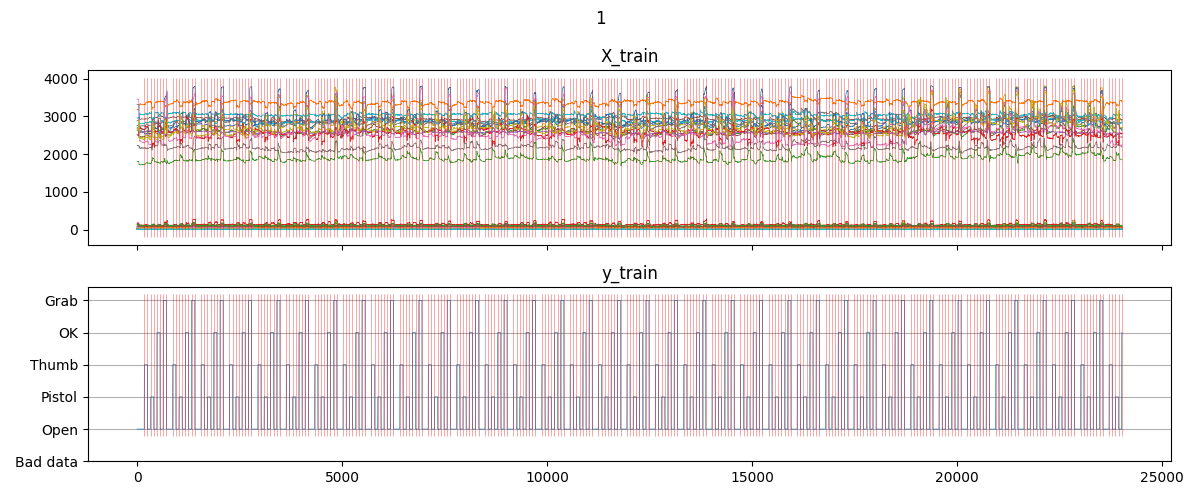

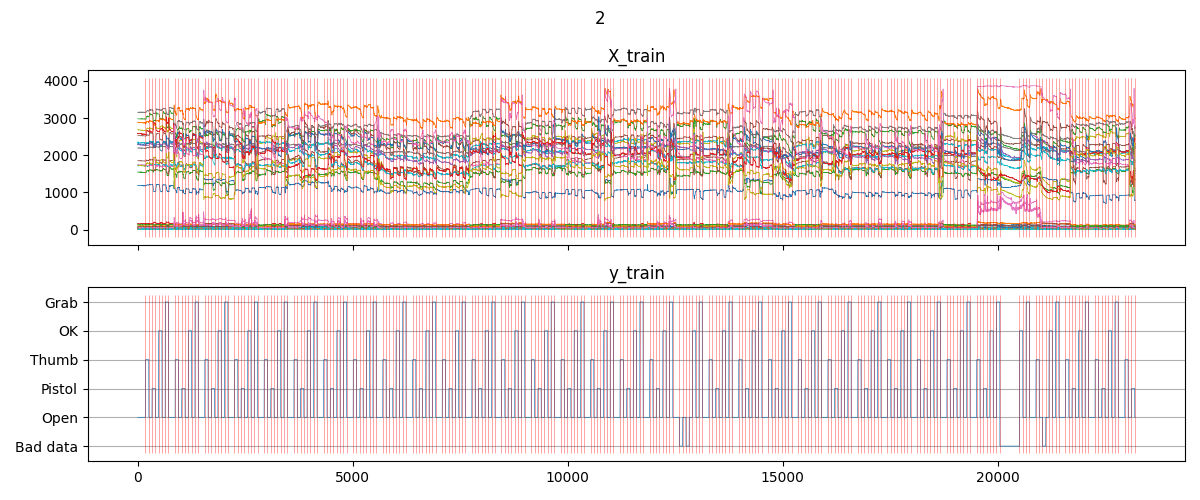

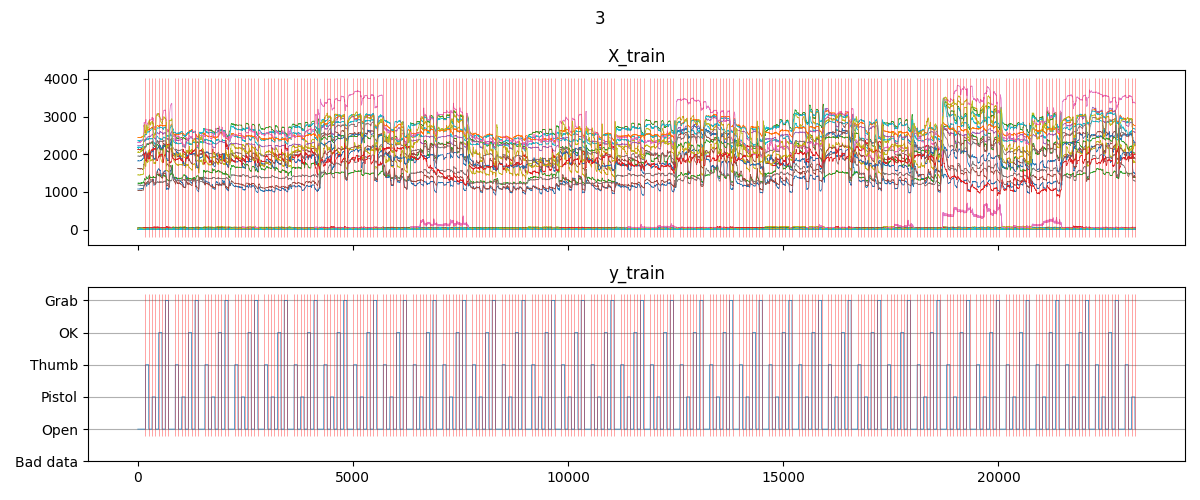

In [15]:
for mount_name, mount in mounts.items():
    X_train = mount['X_train']
    y_train = mount['y_train']
    
    events = np.where(np.abs(np.diff(y_train)) > 0)[0]
    
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
    plt.sca(axx[0])
    plt.plot(X_train, lw=0.5)
    plt.title('X_train')
    yl = plt.ylim()
    plt.vlines(events, *yl, color='r', lw=0.5, alpha=0.5)
    
    plt.sca(axx[1])
    plt.plot(y_train, lw=0.5)
    plt.title('y_train')
    yl = plt.ylim()
    plt.vlines(events, *yl, color='r', lw=0.5, alpha=0.5)
    plt.yticks(
        np.arange(-1, 5),
        ['Bad data', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
    )
    plt.grid(axis='y')
    
    plt.suptitle(f"{mount_name}")
    plt.tight_layout()
    plt.show()

In [16]:
mount['X_train'].T

array([[1080, 1081, 1082, ..., 1476, 1472, 1471],
       [  17,   10,   11, ...,    9,    7,    6],
       [1232, 1232, 1234, ..., 1383, 1383, 1385],
       ...,
       [   7,    6,    6, ...,    8,    6,    5],
       [  27,   27,   20, ...,   27,   26,   24],
       [   9,    9,    8, ...,    6,   23,    7]], dtype=int64)

In [23]:
SFREQ = 1000.0 / 33

for mount_name, mount in mounts.items():
    X_train = mount['X_train']
    y_train = mount['y_train']
    
    raw = mne.io.RawArray(
        data=X_train.T,
        info=mne.create_info(
            ch_names=list(np.arange(50).astype(str)),
            sfreq=SFREQ,
            ch_types='eeg'
        )
    )
    raw_y = mne.io.RawArray(
        data=y_train.reshape(1,-1),
        info=mne.create_info(
            ch_names=['y'],
            sfreq=SFREQ,
            ch_types='misc'
        )
    )
    raw = raw.add_channels([raw_y])
    
    mount['raw'] = raw

Creating RawArray with float64 data, n_channels=50, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.


In [38]:
for mount_name, mount in mounts.items():
    
    raw = mount['raw']
    y_train = mount['y_train']
    
    events = np.where(np.abs(np.diff(y_train)) > 0)[0]

    events = np.stack([
        events,
        np.zeros_like(events),
        np.zeros_like(events)
    ], axis=1)
    
    
    epochs = mne.Epochs(
        raw,
        events=events,
        tmin=-1,
        tmax=1 * 2.5,
        preload=True,
        baseline=None,
        picks='all'
    )
    
    X_train_nn = epochs.copy().pick_types(eeg =True)._data.swapaxes(1, 2)
    y_train_nn = epochs.copy().pick_types(misc=True)._data.swapaxes(1, 2)
    y_train_nn = tf.keras.utils.to_categorical(y_train_nn)
    
    mount['X_train_nn'] = X_train_nn
    mount['y_train_nn'] = y_train_nn

    print(X_train_nn.shape, y_train_nn.shape)

Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 277 events and 107 original time points ...
1 bad epochs dropped
(276, 107, 50) (276, 107, 5)
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 264 events and 107 original time points ...
1 bad epochs dropped
(263, 107, 50) (263, 107, 5)
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 268 events and 107 original time points ...
1 bad epochs dropped
(267, 107, 50) (267, 107, 5)


# Model architecture

In [40]:
_, n_timesteps, n_channels = X_train_nn.shape
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.SimpleRNN(
    units=100,
    return_sequences=True,
    recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2),
)(x)
output = tf.keras.layers.Dense(units=output_units, activation='sigmoid')(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model.summary()

input_shape = (107, 50) | output_units = 5
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 107, 50)]         0         
                                                                 
 batch_normalization_1 (Batc  (None, 107, 50)          200       
 hNormalization)                                                 
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 107, 100)          15100     
                                                                 
 dense_1 (Dense)             (None, 107, 5)            505       
                                                                 
Total params: 15,805
Trainable params: 15,705
Non-trainable params: 100
_________________________________________________________________


In [41]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model train

In [42]:
from tensorflow.keras.metrics import Precision, Recall


for mount_name, mount in mounts.items():
    X_train_nn = mount['X_train_nn']
    y_train_nn = mount['y_train_nn']
    
    m = tf.keras.models.clone_model(model)
    m.compile(
        loss="mean_squared_error",
        metrics=[Precision(), Recall()],
        optimizer=tf.keras.optimizers.Adam(),
    )
    
    history = m.fit(
        X_train_nn,
        y_train_nn, 
        epochs=300,
        verbose=1,
    )
    
    y_pred_train_nn = m.predict(X_train_nn)
    print(y_pred_train_nn.shape)
    
    mount['model'] = m
    mount['y_pred_train_nn'] = y_pred_train_nn

Epoch 1/300
9/9 [==============================] - 7s 76ms/step - loss: 1.9403 - precision: 0.3119 - recall: 0.7026
Epoch 2/300
9/9 [==============================] - 1s 109ms/step - loss: 1.6971 - precision: 0.3991 - recall: 0.7697
Epoch 3/300
9/9 [==============================] - 1s 97ms/step - loss: 1.4853 - precision: 0.4818 - recall: 0.7746
Epoch 4/300
9/9 [==============================] - 1s 74ms/step - loss: 1.3030 - precision: 0.5469 - recall: 0.7598
Epoch 5/300
9/9 [==============================] - 1s 73ms/step - loss: 1.1413 - precision: 0.6056 - recall: 0.7589
Epoch 6/300
9/9 [==============================] - 1s 73ms/step - loss: 1.0024 - precision: 0.6376 - recall: 0.7512
Epoch 7/300
9/9 [==============================] - 1s 74ms/step - loss: 0.8799 - precision: 0.6751 - recall: 0.7461
Epoch 8/300
9/9 [==============================] - 1s 69ms/step - loss: 0.7752 - precision: 0.6932 - recall: 0.7380
Epoch 9/300
9/9 [==============================] - 1s 81ms/step - loss:

## Visualisation

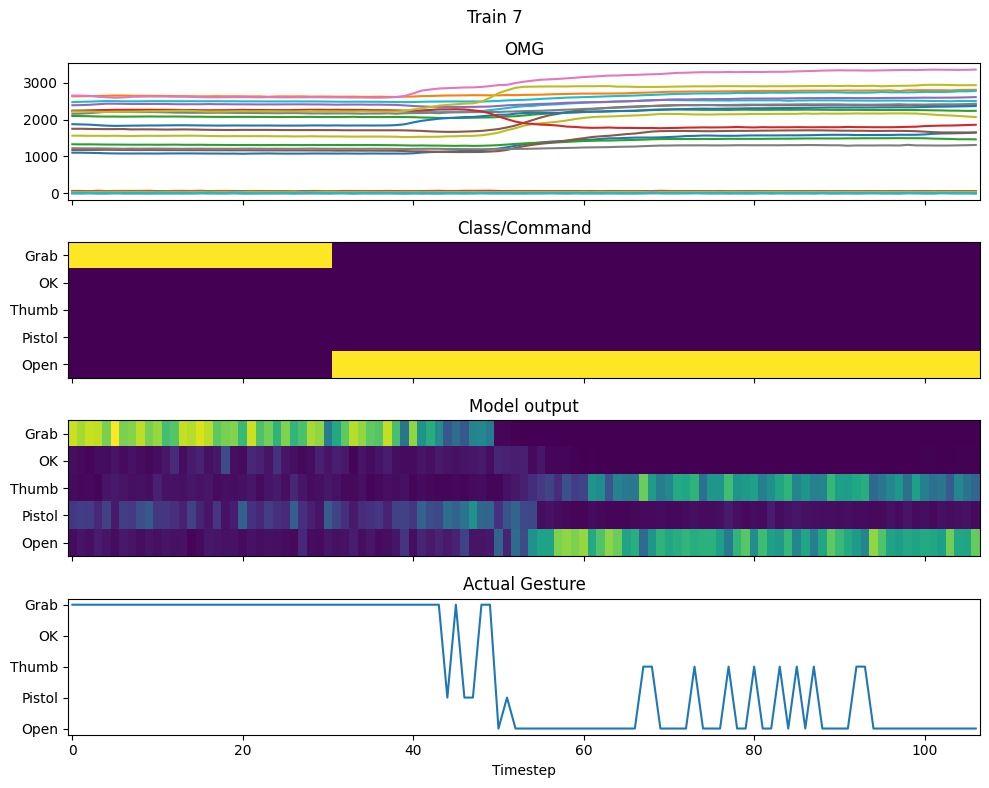

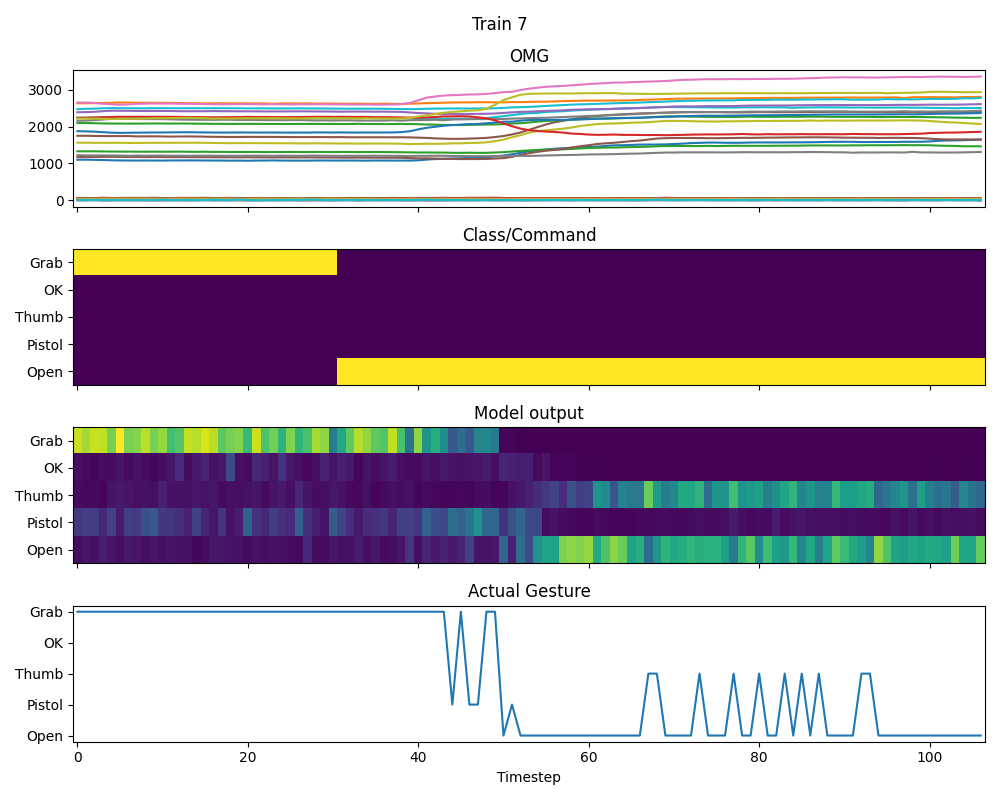

In [43]:
i = 7

fig, axx = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

axx[0].plot(X_train_nn[i])
axx[0].set_title('OMG')

axx[1].imshow(y_train_nn[i].T, origin="lower")
axx[1].set_aspect('auto')
axx[1].set_title('Class/Command')
axx[1].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[2].imshow(y_pred_train_nn[i].T, origin="lower") # , vmin=-0.5, vmax=0.5
axx[2].set_aspect('auto')
axx[2].set_title('Model output')
axx[2].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[3].plot(y_pred_train_nn[i].argmax(axis=-1))
axx[3].set_aspect('auto')
axx[3].set_title('Actual Gesture')
axx[3].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)
axx[3].set_xlabel('Timestep')

plt.suptitle(f'Train {i}')
plt.tight_layout()
plt.gcf()

# Look at `X_test_dataset`

In [44]:
for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    print(f"subject {mount_name}")
    shapes, counts = np.unique(
        [arr.shape for arr in X_test_dataset],
        return_counts=True,
        axis=0
    )
    for shape, count in zip(shapes, counts):
        print(f"\tshape {tuple(shape)} appears {count} times.")

subject 1
	shape (50, 105) appears 303 times.
	shape (50, 181) appears 299 times.
	shape (50, 256) appears 297 times.
subject 2
	shape (50, 105) appears 286 times.
	shape (50, 181) appears 285 times.
	shape (50, 256) appears 284 times.
subject 3
	shape (50, 105) appears 291 times.
	shape (50, 181) appears 282 times.
	shape (50, 256) appears 288 times.


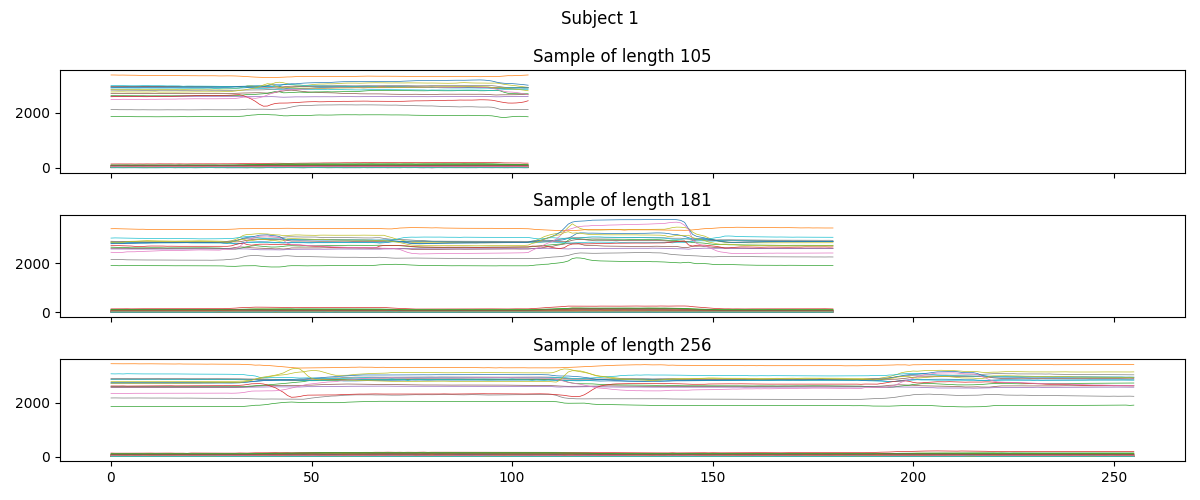

In [45]:
for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    fig, axx = plt.subplots(3, 1, sharex=True, figsize=(12, 5))
    plt.sca(axx[0])
    plt.plot(X_test_dataset[3].T, lw=0.5)
    plt.title('Sample of length 105')
    
    plt.sca(axx[1])
    plt.plot(X_test_dataset[1].T, lw=0.5)
    plt.title('Sample of length 181')
    
    plt.sca(axx[2])
    plt.plot(X_test_dataset[8].T, lw=0.5)
    plt.title('Sample of length 256')
    
    plt.suptitle(f"Subject {mount_name}")
    plt.tight_layout()
    plt.show()
    
    break

# Predict test & submit

In [ ]:
for mount_name, mount in mounts.items():
    m = mount['model']
    X_train_nn = mount['X_train_nn']
    X_test_dataset = mount['X_test_dataset']
    
    y_pred_test_nn = []
    for i in range(len(X_test_dataset)):
        X_test_i = np.expand_dims(X_test_dataset[i], axis=0).swapaxes(1, 2).astype(np.float64)
        y_pred_test_nn += [m.predict(X_test_i, verbose=0)]
        
    y_pred_test = [arr.argmax(axis=-1) for arr in y_pred_test_nn]
    
    print(len(y_pred_test))
    assert len(y_pred_test) == y_test.query("subject_id == @mount_name")['sample'].nunique()
    
    mount['y_pred_test_nn'] = y_pred_test_nn
    mount['y_pred_test'] = y_pred_test

In [ ]:
y_pred_test_res = []
for mount_name, mount in mounts.items():
    y_pred_test_res.extend(mount['y_pred_test'])
y_pred_test_res = np.concatenate(y_pred_test_res, axis=-1)[0]

assert y_pred_test_res.shape[0] == y_test.shape[0]

In [ ]:
y_test_submit = y_test[['subject_id-sample-timestep', 'class']]
y_test_submit['class'] = y_pred_test_res
y_test_submit.to_csv('./y_test_submit_rnn_baseline.csv', index=False)

y_test_submit

# Model architecture LSTM

In [51]:
# Функция для расчета метрики f1_score 
# Примечание: Metrics have been removed from Keras core on 2.0 version
# https://stackoverflow.com/questions/66554207/calculating-micro-f-1-score-in-keras

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """
        Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """
        Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [58]:
# Callbacks that used for training model
def callbacks(lr):
    checkpoint = ModelCheckpoint(PATH_BEST_MODEL + '\\' + 'best_model.hdf5', monitor='f1', 
                                 verbose=1, mode='max', save_best_only=True)
    earlystop = EarlyStopping(monitor='f1', mode='max', patience=300, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='f1', mode='max', factor=0.9, patience=10, verbose=1, 
                                  min_lr=lr/10000)
    return [checkpoint, earlystop, reduce_lr]

callbacks_list = callbacks(lr=0.001)

In [60]:
_, n_timesteps, n_channels = X_train_nn.shape
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))

#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)(x) 
x = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)(x)  
x = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)(x)  
x = tf.keras.layers.LSTM(100, return_sequences=True)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)


output = tf.keras.layers.Dense(units=output_units, activation='softmax')(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model.summary()

input_shape = (107, 50) | output_units = 5
Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 107, 50)]    0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 107, 100),   60400       ['input_5[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_9 (LSTM)                  [(None, 107, 100),   80400       ['lstm_8[0][0]',                 
                                 (None, 100),      

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model train

In [ ]:
#from tensorflow.keras.metrics import Precision, Recall


for mount_name, mount in mounts.items():
    X_train_nn = mount['X_train_nn']
    y_train_nn = mount['y_train_nn']
    
    m = tf.keras.models.clone_model(model)
    m.compile(
        loss="categorical_crossentropy",
        metrics=[f1],
        optimizer=tf.keras.optimizers.Adam(),
    )
    
    history = m.fit(
        X_train_nn,
        y_train_nn, 
        validation_split=0.15,
        epochs=1500,
        verbose=1,
        callbacks = callbacks_list
    )
    
    y_pred_train_nn = m.predict(X_train_nn)
    print(y_pred_train_nn.shape)
    
    mount['model'] = m
    mount['y_pred_train_nn'] = y_pred_train_nn

## Visualisation

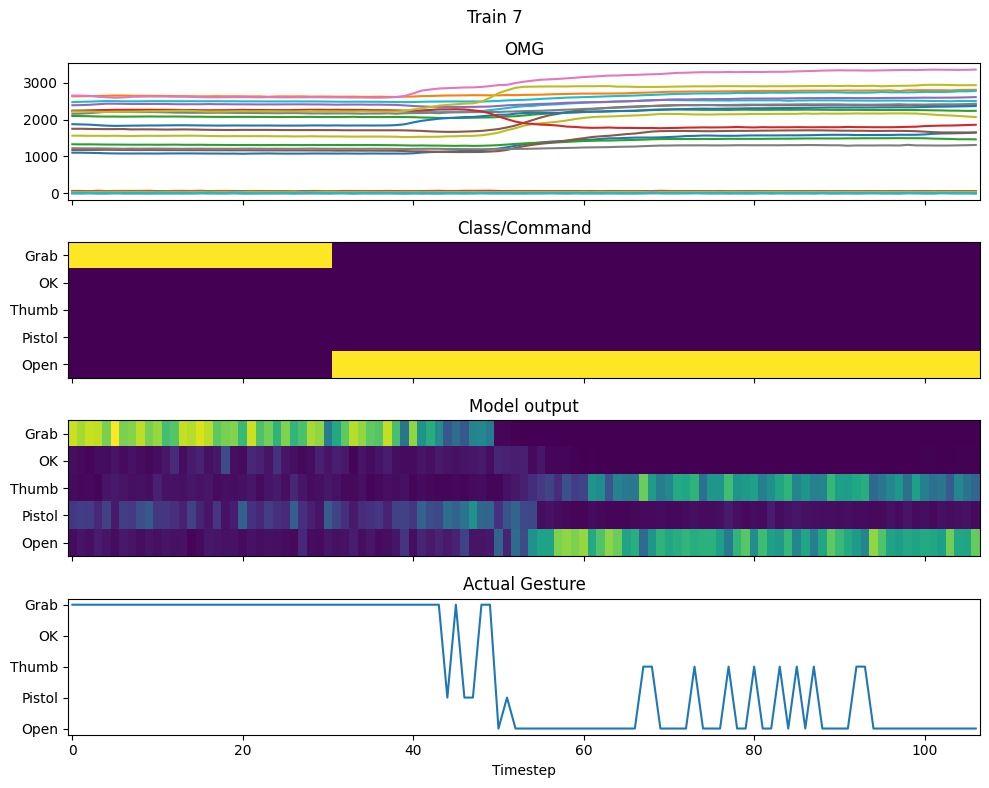

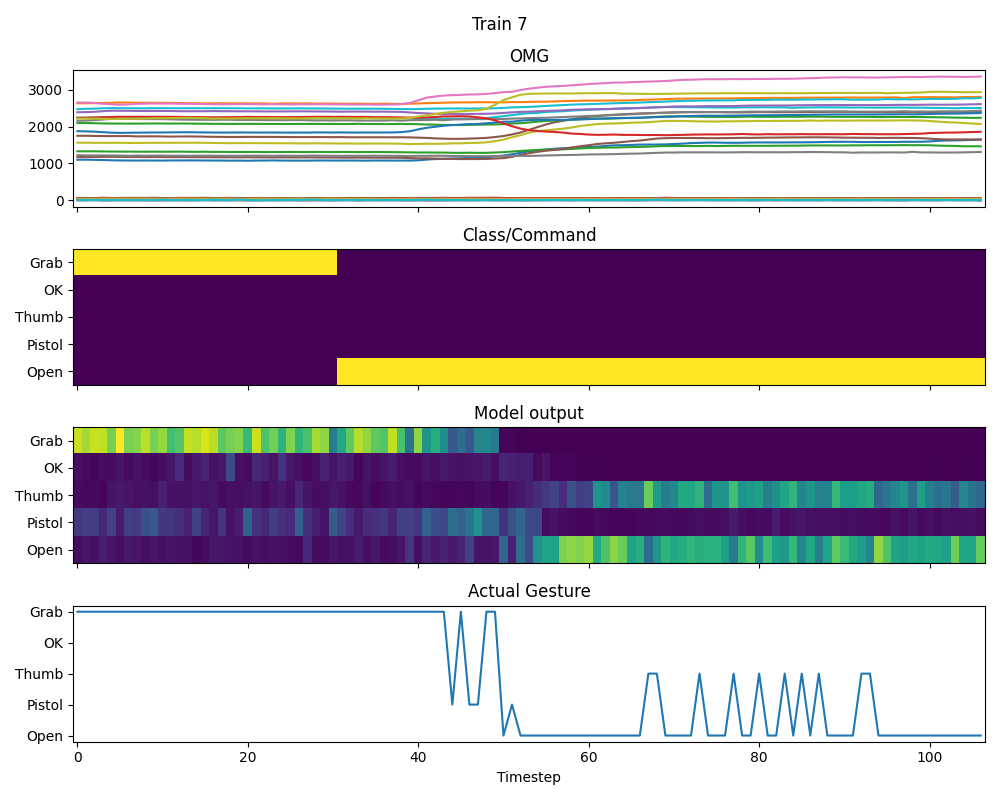

In [ ]:
i = 7

fig, axx = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

axx[0].plot(X_train_nn[i])
axx[0].set_title('OMG')

axx[1].imshow(y_train_nn[i].T, origin="lower")
axx[1].set_aspect('auto')
axx[1].set_title('Class/Command')
axx[1].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[2].imshow(y_pred_train_nn[i].T, origin="lower") # , vmin=-0.5, vmax=0.5
axx[2].set_aspect('auto')
axx[2].set_title('Model output')
axx[2].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[3].plot(y_pred_train_nn[i].argmax(axis=-1))
axx[3].set_aspect('auto')
axx[3].set_title('Actual Gesture')
axx[3].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)
axx[3].set_xlabel('Timestep')

plt.suptitle(f'Train {i}')
plt.tight_layout()
plt.gcf()

# Look at `X_test_dataset` LSTM

In [ ]:
for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    print(f"subject {mount_name}")
    shapes, counts = np.unique(
        [arr.shape for arr in X_test_dataset],
        return_counts=True,
        axis=0
    )
    for shape, count in zip(shapes, counts):
        print(f"\tshape {tuple(shape)} appears {count} times.")

In [ ]:
for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    fig, axx = plt.subplots(3, 1, sharex=True, figsize=(12, 5))
    plt.sca(axx[0])
    plt.plot(X_test_dataset[3].T, lw=0.5)
    plt.title('Sample of length 105')
    
    plt.sca(axx[1])
    plt.plot(X_test_dataset[1].T, lw=0.5)
    plt.title('Sample of length 181')
    
    plt.sca(axx[2])
    plt.plot(X_test_dataset[8].T, lw=0.5)
    plt.title('Sample of length 256')
    
    plt.suptitle(f"Subject {mount_name}")
    plt.tight_layout()
    plt.show()
    
    break

# Predict test & submit LSTM

In [ ]:
for mount_name, mount in mounts.items():
    m = mount['model']
    X_train_nn = mount['X_train_nn']
    X_test_dataset = mount['X_test_dataset']
    
    y_pred_test_nn = []
    for i in range(len(X_test_dataset)):
        X_test_i = np.expand_dims(X_test_dataset[i], axis=0).swapaxes(1, 2).astype(np.float64)
        y_pred_test_nn += [m.predict(X_test_i, verbose=0)]
        
    y_pred_test = [arr.argmax(axis=-1) for arr in y_pred_test_nn]
    
    print(len(y_pred_test))
    assert len(y_pred_test) == y_test.query("subject_id == @mount_name")['sample'].nunique()
    
    mount['y_pred_test_nn'] = y_pred_test_nn
    mount['y_pred_test'] = y_pred_test

In [ ]:
y_pred_test_res = []
for mount_name, mount in mounts.items():
    y_pred_test_res.extend(mount['y_pred_test'])
y_pred_test_res = np.concatenate(y_pred_test_res, axis=-1)[0]

assert y_pred_test_res.shape[0] == y_test.shape[0]

In [ ]:
y_test_submit = y_test[['subject_id-sample-timestep', 'class']]
y_test_submit['class'] = y_pred_test_res
y_test_submit.to_csv('./y_test_submit_rnn_LSTM.csv', index=False)

y_test_submit